In [ ]:
import pandas as pd
import numpy as np 
import json
import re
import pickle
import math
import tqdm
from scipy.spatial import cKDTree
from fuzzywuzzy import fuzz
import pickle
from shapely import wkt
import networkx as nx
from collections import Counter
import geopandas as gpd
from shapely.geometry import Polygon
import transbigdata as tbd
from shapely.wkt import loads
from itertools import combinations
from tqdm import trange
from tqdm import tqdm
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import matplotlib.pyplot as plt
import geopandas
from scipy.stats import pearsonr
from shapely import geometry as geo
from shapely import wkt
from sklearn import metrics
import shapely
import itertools

### 计算模型的预测准确率

In [ ]:
with open('data/dt_2019', 'rb') as f:
    dt_2019 = pickle.load(f).reset_index(drop=True)

with open('data/data_lockdown_empirical_2021', 'rb') as f:
    dt_2021_ini = pickle.load(f).reset_index(drop = True)

file_id = 7

with open(f'test_data_{file_id}/x_states_pre', 'rb') as f:
    x_states_pre = pickle.load(f)

with open(f'test_data_{file_id}/y_states_pre', 'rb') as f:
    y_states_pre = pickle.load(f)

with open(f'test_data_{file_id}/x_states_post', 'rb') as f:
    x_states_post = pickle.load(f)

with open(f'test_data_{file_id}/y_states_post', 'rb') as f:
    y_states_post = pickle.load(f)

In [ ]:
with open('data/data_prelockdown_empirical', 'rb') as f:
    data_prelockdown_empirical = pickle.load(f).reset_index(drop = True)

with open('data/data_lockdown_empirical', 'rb') as f:
    data_lockdown_empirical = pickle.load(f).reset_index(drop = True)

In [ ]:
with open('data/geom_dict_layery', 'rb') as f:
    geom_y_dict = pickle.load(f)
index_geom = {}
for k, v in geom_y_dict.items():
    index_geom[v] = k

In [ ]:
data_prelockdown_empirical['geom'] = data_prelockdown_empirical['geom_index'].apply(lambda index: index_geom.get(index, None))
data_lockdown_empirical['geom'] = data_lockdown_empirical['geom_index'].apply(lambda index: index_geom.get(index, None))

In [ ]:
dt_2019_new = dt_2019.loc[~pd.isna(dt_2019['geom_index']), ]

dt_2021_new = dt_2021_ini.copy()
dt_2021_new = dt_2021_new.loc[~pd.isna(dt_2021_new['geom_index']), ]

#### pre阶段的预测准确率——R_2

In [ ]:
dt_prelockdown_empirical = data_prelockdown_empirical.groupby('geom')['states'].value_counts().reset_index()
dt_prelockdown_empirical = dt_prelockdown_empirical.pivot(index = 'geom', columns = 'states', values = 'count').reset_index()
# 去掉含有na的样本
dt_prelockdown_empirical = dt_prelockdown_empirical.loc[~((pd.isna(dt_prelockdown_empirical['death'])) | (pd.isna(dt_prelockdown_empirical['remaining']))), ]
dt_prelockdown_empirical  = dt_prelockdown_empirical .fillna(value = 0)
dt_prelockdown_empirical['n'] = dt_prelockdown_empirical['death'] + dt_prelockdown_empirical['remaining']
dt_prelockdown_empirical['death_rate'] = dt_prelockdown_empirical['death'] / dt_prelockdown_empirical['n']
dt_prelockdown_empirical['remaining_rate'] = dt_prelockdown_empirical['remaining'] / dt_prelockdown_empirical['n']

In [ ]:
for pre in range(1, len(y_states_pre)):
    data_prelockdown_simulation = dt_2019_new.copy()
    data_prelockdown_simulation['states'] = x_states_pre[pre]

    data_prelockdown_simulation['geom'] = data_prelockdown_simulation['geom_index'].apply(lambda index: index_geom.get(index, None))
    # 注意，因为simulation的算法缘故，很多地区的节点是直接全部封控或者全部恢复的，所以rate存在很多的1，0值
    dt_prelockdown_simulation = data_prelockdown_simulation.groupby('geom')['states'].value_counts().reset_index()
    dt_prelockdown_simulation = dt_prelockdown_simulation.pivot(index = 'geom', columns = 'states', values = 'count').reset_index()
    # 去掉含有na的样本
    dt_prelockdown_simulation.loc[~((pd.isna(dt_prelockdown_simulation['death'])) | (pd.isna(dt_prelockdown_simulation['remaining']))), ]
    dt_prelockdown_simulation  = dt_prelockdown_simulation.fillna(value = 0)
    dt_prelockdown_simulation['n'] = dt_prelockdown_simulation['death'] + dt_prelockdown_simulation['remaining']
    dt_prelockdown_simulation['death_rate'] = dt_prelockdown_simulation['death'] / dt_prelockdown_simulation['n']
    dt_prelockdown_simulation['remaining_rate'] = dt_prelockdown_simulation['remaining'] / dt_prelockdown_simulation['n']
    # dt_prelockdown_simulation.loc[(dt_prelockdown_simulation['death_rate'] < 1) & (dt_prelockdown_simulation['death_rate'] > 0), ]

    # 对prelockdown阶段的经验和模拟中的各个栅格的数据进行对齐
    geom_simulation = dt_prelockdown_simulation['geom'].to_list()
    geom_empirical = dt_prelockdown_empirical['geom'].to_list()
    geoms = list(set(geom_simulation).intersection(geom_empirical))
    prelockdown_results = pd.DataFrame()
    prelockdown_results['geoms'] = geoms
    prelockdown_results['empirical_death_rate'] = dt_prelockdown_empirical.set_index('geom').loc[geoms, 'death_rate'].to_list()
    prelockdown_results['simulation_death_rate'] = dt_prelockdown_simulation.set_index('geom').loc[geoms, 'death_rate'].to_list()
    x = prelockdown_results['empirical_death_rate'].to_list()
    y = prelockdown_results['simulation_death_rate'].to_list()
    print(f'第{pre}天，未封锁阶段的空间相关性：{pearsonr(x, y)}\n')

第1天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.024376260773149014, pvalue=0.3348874731744512)

第2天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.04211073502625494, pvalue=0.09563831689593703)

第3天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.12119085610768895, pvalue=1.4995350975936413e-06)

第4天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.13384441444822498, pvalue=1.0491747107127058e-07)

第5天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.13548753513550738, pvalue=7.289530868926693e-08)

第6天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.146170023881075, pvalue=6.1428948539899185e-09)

第7天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.1705109705676388, pvalue=1.089441047061597e-11)

第8天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.15094213117937602, pvalue=1.9161103118572718e-09)

第9天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.10521736591334008, pvalue=3.0017809074031595e-05)

第10天，未封锁阶段的空间相关性：PearsonRResult(statistic=0.10491036169824902, pvalue=3.167371178368074e-05)



In [ ]:
# pre = 8 是最大相关所在天数
pre = 8
data_prelockdown_simulation = dt_2019_new.copy()
data_prelockdown_simulation['states'] = x_states_pre[pre]

data_prelockdown_simulation['geom'] = data_prelockdown_simulation['geom_index'].apply(lambda index: index_geom.get(index, None))
# 注意，因为simulation的算法缘故，很多地区的节点是直接全部封控或者全部恢复的，所以rate存在很多的1，0值
dt_prelockdown_simulation = data_prelockdown_simulation.groupby('geom')['states'].value_counts().reset_index()
dt_prelockdown_simulation = dt_prelockdown_simulation.pivot(index = 'geom', columns = 'states', values = 'count').reset_index()
# 去掉含有na的样本
dt_prelockdown_simulation.loc[~((pd.isna(dt_prelockdown_simulation['death'])) | (pd.isna(dt_prelockdown_simulation['remaining']))), ]
dt_prelockdown_simulation  = dt_prelockdown_simulation.fillna(value = 0)
dt_prelockdown_simulation['n'] = dt_prelockdown_simulation['death'] + dt_prelockdown_simulation['remaining']
dt_prelockdown_simulation['death_rate'] = dt_prelockdown_simulation['death'] / dt_prelockdown_simulation['n']
dt_prelockdown_simulation['remaining_rate'] = dt_prelockdown_simulation['remaining'] / dt_prelockdown_simulation['n']
# dt_prelockdown_simulation.loc[(dt_prelockdown_simulation['death_rate'] < 1) & (dt_prelockdown_simulation['death_rate'] > 0), ]

# 对prelockdown阶段的经验和模拟中的各个栅格的数据进行对齐
geom_simulation = dt_prelockdown_simulation['geom'].to_list()
geom_empirical = dt_prelockdown_empirical['geom'].to_list()
geoms = list(set(geom_simulation).intersection(geom_empirical))
prelockdown_results = pd.DataFrame()
prelockdown_results['geoms'] = geoms
prelockdown_results['empirical'] = dt_prelockdown_empirical.set_index('geom').loc[geoms, 'death_rate'].to_list()
prelockdown_results['simulation'] = dt_prelockdown_simulation.set_index('geom').loc[geoms, 'death_rate'].to_list()
x = prelockdown_results['empirical'].to_list()
y = prelockdown_results['simulation'].to_list()
prelockdown_results = prelockdown_results.melt(id_vars='geoms', value_vars = ['empirical', 'simulation'], var_name = 'empirical_simulation', value_name = 'rate')
prelockdown_results['stage'] = 'prelockdown'

#### post阶段的预测准确率——R_2

In [ ]:
dt_lockdown_empirical = data_lockdown_empirical.groupby('geom')['states'].value_counts().reset_index()
dt_lockdown_empirical = dt_lockdown_empirical.pivot(index = 'geom', columns = 'states', values = 'count').reset_index()
# 去掉含有na的样本
dt_lockdown_empirical.loc[~((pd.isna(dt_lockdown_empirical['death'])) | (pd.isna(dt_lockdown_empirical['remaining']))), ]
dt_lockdown_empirical  = dt_lockdown_empirical.fillna(value = 0)
dt_lockdown_empirical['n'] = dt_lockdown_empirical['death'] + dt_lockdown_empirical['remaining']
dt_lockdown_empirical['death_rate'] = dt_lockdown_empirical['death'] / dt_lockdown_empirical['n']
dt_lockdown_empirical['remaining_rate'] = dt_lockdown_empirical['remaining'] / dt_lockdown_empirical['n']

In [ ]:
for post in range(1, len(y_states_post)):

    data_lockdown_simulation = dt_2019_new.copy()
    data_lockdown_simulation['states'] = x_states_post[post]

    data_lockdown_simulation['geom'] = data_lockdown_simulation['geom_index'].apply(lambda index: index_geom.get(index, None))

    dt_lockdown_simulation = data_lockdown_simulation.groupby('geom')['states'].value_counts().reset_index()
    dt_lockdown_simulation = dt_lockdown_simulation.pivot(index = 'geom', columns = 'states', values = 'count').reset_index()
    # 去掉含有na的样本
    dt_lockdown_simulation.loc[~((pd.isna(dt_lockdown_simulation['death'])) | (pd.isna(dt_lockdown_simulation['remaining']))), ]
    dt_lockdown_simulation  = dt_lockdown_simulation.fillna(value = 0)
    dt_lockdown_simulation['n'] = dt_lockdown_simulation['death'] + dt_lockdown_simulation['remaining']
    dt_lockdown_simulation['death_rate'] = dt_lockdown_simulation['death'] / dt_lockdown_simulation['n']
    dt_lockdown_simulation['remaining_rate'] = dt_lockdown_simulation['remaining'] / dt_lockdown_simulation['n']
    # dt_lockdown_simulation.loc[(dt_lockdown_simulation['death_rate'] < 1) & (dt_lockdown_simulation['death_rate'] > 0), ]

    # 对prelockdown阶段的经验和模拟中的各个栅格的数据进行对齐
    geom_simulation = dt_lockdown_simulation['geom'].to_list()
    geom_empirical = dt_lockdown_empirical['geom'].to_list()
    geoms = list(set(geom_simulation).intersection(geom_empirical))

    lockdown_results = pd.DataFrame()
    lockdown_results['geoms'] = geoms
    lockdown_results['empirical_death_rate'] = dt_lockdown_empirical.set_index('geom').loc[geoms, 'death_rate'].to_list()
    lockdown_results['simulation_death_rate'] = dt_lockdown_simulation.set_index('geom').loc[geoms, 'death_rate'].to_list()
    x = lockdown_results['empirical_death_rate'].to_list()
    y = lockdown_results['simulation_death_rate'].to_list()
    print(f'第{post}天，封锁阶段的经验和模拟：{pearsonr(x, y)}\n')

第1天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.10455322176920381, pvalue=2.481250758844506e-05)

第2天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.07899536320268688, pvalue=0.0014625104534468803)

第3天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.09717739046267299, pvalue=8.944593634738176e-05)

第4天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.10615859037836438, pvalue=1.8554903453128934e-05)

第5天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.10745494680359956, pvalue=1.4629503737766638e-05)

第6天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.0893170843378667, pvalue=0.00031899628668262793)

第7天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.10107358850454243, pvalue=4.592868590784653e-05)

第8天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.12560880438679978, pvalue=3.939590825076746e-07)

第9天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.08930340725871015, pvalue=0.00031967574559856683)

第10天，封锁阶段的经验和模拟：PearsonRResult(statistic=0.11791505812674687, pvalue=1.9461548001660935e-06)



In [ ]:
# pre = 8 是最大相关所在天数
pre = 8
data_lockdown_simulation = dt_2019_new.copy()
data_lockdown_simulation['states'] = x_states_post[pre]

data_lockdown_simulation['geom'] = data_lockdown_simulation['geom_index'].apply(lambda index: index_geom.get(index, None))
# 注意，因为simulation的算法缘故，很多地区的节点是直接全部封控或者全部恢复的，所以rate存在很多的1，0值
dt_lockdown_simulation = data_lockdown_simulation.groupby('geom')['states'].value_counts().reset_index()
dt_lockdown_simulation = dt_lockdown_simulation.pivot(index = 'geom', columns = 'states', values = 'count').reset_index()
# 去掉含有na的样本
dt_lockdown_simulation.loc[~((pd.isna(dt_lockdown_simulation['death'])) | (pd.isna(dt_lockdown_simulation['remaining']))), ]
dt_lockdown_simulation  = dt_lockdown_simulation.fillna(value = 0)
dt_lockdown_simulation['n'] = dt_lockdown_simulation['death'] + dt_lockdown_simulation['remaining']
dt_lockdown_simulation['death_rate'] = dt_lockdown_simulation['death'] / dt_lockdown_simulation['n']
dt_lockdown_simulation['remaining_rate'] = dt_lockdown_simulation['remaining'] / dt_lockdown_simulation['n']
# dt_lockdown_simulation.loc[(dt_lockdown_simulation['death_rate'] < 1) & (dt_lockdown_simulation['death_rate'] > 0), ]

# 对lockdown阶段的经验和模拟中的各个栅格的数据进行对齐
geom_simulation = dt_lockdown_simulation['geom'].to_list()
geom_empirical = dt_lockdown_empirical['geom'].to_list()
geoms = list(set(geom_simulation).intersection(geom_empirical))
lockdown_results = pd.DataFrame()
lockdown_results['geoms'] = geoms
lockdown_results['empirical'] = dt_lockdown_empirical.set_index('geom').loc[geoms, 'death_rate'].to_list()
lockdown_results['simulation'] = dt_lockdown_simulation.set_index('geom').loc[geoms, 'death_rate'].to_list()
x = lockdown_results['empirical'].to_list()
y = lockdown_results['simulation'].to_list()
lockdown_results = lockdown_results.melt(id_vars='geoms', value_vars = ['empirical', 'simulation'], var_name = 'empirical_simulation', value_name = 'rate')
lockdown_results['stage'] = 'lockdwon'

In [ ]:
results = pd.concat([prelockdown_results, lockdown_results])
results['type'] = results[['empirical_simulation', 'stage']].apply(lambda row: row[0] + '_' + row[1], axis = 1)
results = results.pivot(index='geoms', columns='type', values='rate').reset_index()
results = results.loc[~pd.isna(results['empirical_lockdwon']) & ~pd.isna(results['empirical_prelockdown']) & ~pd.isna(results['simulation_lockdwon']) & ~pd.isna(results['simulation_prelockdown']), ]
results.to_csv('geom_deathrate.csv', index=False)

### 空间相关性：病毒发生率和餐馆死亡率之间的关系（这是对模型基本假定的检验）

#### pre阶段的空间相关性

In [ ]:
with open('data/dt_2019', 'rb') as f:
    dt_2019_ini = pickle.load(f).reset_index(drop=True)

with open(f'test_data_{file_id}/x_states_pre', 'rb') as f:
    x_states_pre = pickle.load(f)

with open(f'test_data_{file_id}/y_states_pre', 'rb') as f:
    y_states_pre = pickle.load(f)

with open(f'test_data_{file_id}/x_states_post', 'rb') as f:
    x_states_post = pickle.load(f)

with open(f'test_data_{file_id}/y_states_post', 'rb') as f:
    y_states_post = pickle.load(f)

In [ ]:
dt_2019_new = dt_2019.loc[~pd.isna(dt_2019['geom_index']), ]

In [ ]:
for d_id in range(1, len(y_states_post)):
    dt_2019_mini = dt_2019_new.copy()
    dt_2019_mini['x_state'] = x_states_pre[d_id]
    dt_2019_mini = dt_2019_mini.loc[~pd.isna(dt_2019_mini['geom_index']), ]
    geom_index = dt_2019_mini['geom_index'].to_list()
    y_state = []
    for index in geom_index:
        y_state.append(y_states_pre[d_id][int(index)])
    dt_2019_mini['y_state'] = y_state
    dt_2019_mini.groupby('y_state')['states'].value_counts()

    dt_prelockdown_simulation = dt_2019_mini.groupby('geom_index')['x_state'].value_counts().reset_index()
    dt_prelockdown_simulation = dt_prelockdown_simulation.pivot(index = 'geom_index', columns = 'x_state', values = 'count').reset_index()
    # 去掉含有na的样本
    dt_prelockdown_simulation.loc[~((pd.isna(dt_prelockdown_simulation['death'])) | (pd.isna(dt_prelockdown_simulation['remaining']))), ]
    dt_prelockdown_simulation  = dt_prelockdown_simulation.fillna(value = 0)
    dt_prelockdown_simulation['n'] = dt_prelockdown_simulation['death'] + dt_prelockdown_simulation['remaining']
    dt_prelockdown_simulation['death_rate'] = dt_prelockdown_simulation['death'] / dt_prelockdown_simulation['n']
    dt_prelockdown_simulation['remaining_rate'] = dt_prelockdown_simulation['remaining'] / dt_prelockdown_simulation['n']
    geom_index = dt_prelockdown_simulation['geom_index'].to_list()
    y_state = []
    for index in geom_index:
        y_state.append(y_states_pre[d_id][int(index)])
    dt_prelockdown_simulation['y_state'] = y_state
    x = dt_prelockdown_simulation['y_state'].to_list()
    y = dt_prelockdown_simulation['remaining_rate'].to_list()
    p = pearsonr(x, y)
    print(f'\n第{d_id}天的相关系数为{p}')


第1天的相关系数为PearsonRResult(statistic=0.056340866684060215, pvalue=0.01782640384558398)

第2天的相关系数为PearsonRResult(statistic=0.24413375420803965, pvalue=2.0964294505322024e-25)

第3天的相关系数为PearsonRResult(statistic=0.28225268734508907, pvalue=9.739972827699313e-34)

第4天的相关系数为PearsonRResult(statistic=0.25223900400230687, pvalue=4.6069014368486195e-27)

第5天的相关系数为PearsonRResult(statistic=0.29284871342043367, pvalue=2.661815364189555e-36)

第6天的相关系数为PearsonRResult(statistic=0.23596523644221132, pvalue=8.548161344467327e-24)

第7天的相关系数为PearsonRResult(statistic=0.31689982981325665, pvalue=1.549095862452664e-42)

第8天的相关系数为PearsonRResult(statistic=0.2508162428073926, pvalue=9.095560577281044e-27)

第9天的相关系数为PearsonRResult(statistic=0.36501824064093363, pvalue=7.584454244835645e-57)

第10天的相关系数为PearsonRResult(statistic=0.32885255883277903, pvalue=7.406805566952724e-46)


#### POST阶段的模拟数据相关性测试

In [ ]:
# dt_2019_mini = dt_2019_mini_new.copy()
dt_2019_mini = dt_2019_new.copy()
dt_2019_mini['x_state'] = x_states_post[d_id]
dt_2019_mini = dt_2019_mini.loc[~pd.isna(dt_2019_mini['geom_index']), ]
geom_index = dt_2019_mini['geom_index'].to_list()
y_state = []
for index in geom_index:
    y_state.append(y_states_post[d_id][int(index)])
dt_2019_mini['y_state'] = y_state
dt_2019_mini.groupby('y_state')['states'].value_counts()


y_state  states   
0.0      death        5841
         remaining    4005
1.0      death         984
         remaining     721
Name: count, dtype: int64

In [ ]:
for d_id in range(1, len(y_states_post)):
    # dt_2019_mini = dt_2019_mini_new.copy()
    dt_2019_mini = dt_2019_mini.copy()
    dt_2019_mini['x_state'] = x_states_post[d_id]
    dt_2019_mini = dt_2019_mini.loc[~pd.isna(dt_2019_mini['geom_index']), ]
    geom_index = dt_2019_mini['geom_index'].to_list()
    y_state = []
    for index in geom_index:
        y_state.append(y_states_post[d_id][int(index)])
    dt_2019_mini['y_state'] = y_state
    # dt_2019_mini.groupby('y_state')['states'].value_counts()
    # print(f'封控区对比度: {1663 / 1141} \n 正常区对比度: {5162 / 3585}')
    dt_lockdown_simulation = dt_2019_mini.groupby('geom_index')['x_state'].value_counts().reset_index()
    dt_lockdown_simulation = dt_lockdown_simulation.pivot(index = 'geom_index', columns = 'x_state', values = 'count').reset_index()
    # 去掉含有na的样本
    dt_lockdown_simulation.loc[~((pd.isna(dt_lockdown_simulation['death'])) | (pd.isna(dt_lockdown_simulation['remaining']))), ]
    dt_lockdown_simulation  = dt_lockdown_simulation.fillna(value = 0)
    dt_lockdown_simulation['n'] = dt_lockdown_simulation['death'] + dt_lockdown_simulation['remaining']
    dt_lockdown_simulation['death_rate'] = dt_lockdown_simulation['death'] / dt_lockdown_simulation['n']
    dt_lockdown_simulation['remaining_rate'] = dt_lockdown_simulation['remaining'] / dt_lockdown_simulation['n']
    geom_index = dt_lockdown_simulation['geom_index'].to_list()
    y_state = []
    for index in geom_index:
        y_state.append(y_states_post[d_id][int(index)])
    dt_lockdown_simulation['y_state'] = y_state
    x = dt_lockdown_simulation['y_state'].to_list()
    y = dt_lockdown_simulation['remaining_rate'].to_list()
    p = pearsonr(x, y)
    print(f'\n第{d_id}天的相关系数为{p}')


第1天的相关系数为PearsonRResult(statistic=0.5114052228394514, pvalue=3.6112673905604395e-85)

第2天的相关系数为PearsonRResult(statistic=0.4084865079428582, pvalue=5.141539476905566e-52)

第3天的相关系数为PearsonRResult(statistic=0.3646803301243947, pvalue=4.78476368178544e-41)

第4天的相关系数为PearsonRResult(statistic=0.3805129716020893, pvalue=8.069150376295354e-45)

第5天的相关系数为PearsonRResult(statistic=0.3419907701755939, pvalue=5.35906439878249e-36)

第6天的相关系数为PearsonRResult(statistic=0.35824634329349336, pvalue=1.424725390785817e-39)

第7天的相关系数为PearsonRResult(statistic=0.31522838807925, pvalue=1.4748455522740468e-30)

第8天的相关系数为PearsonRResult(statistic=0.31038366284454416, pvalue=1.2475368676183317e-29)

第9天的相关系数为PearsonRResult(statistic=0.3487496408179309, pvalue=1.8535880540011639e-37)

第10天的相关系数为PearsonRResult(statistic=0.31627667475921994, pvalue=9.24321326580387e-31)

第11天的相关系数为PearsonRResult(statistic=0.34272537648286616, pvalue=3.732732183316682e-36)

第12天的相关系数为PearsonRResult(statistic=0.3794998265767796, pval

### 计算经验数据的空间相关性

In [ ]:
with open('data/data_prelockdown_empirical', 'rb') as f:
    data_prelockdown_empirical = pickle.load(f).reset_index(drop = True)

with open('data/data_lockdown_empirical', 'rb') as f:
    data_lockdown_empirical = pickle.load(f).reset_index(drop = True)

In [ ]:
with open('data/risk_layer_y_pre', 'rb') as f:
    risk_layer_y_pre = pickle.load(f)

with open('data/risk_layer_y_post', 'rb') as f:
    risk_layer_y_post = pickle.load(f)

In [ ]:
pre_index = data_prelockdown_empirical.index
geom_index = data_prelockdown_empirical.geom_index
ls_pre = []
for i in np.where(~pd.isna(geom_index))[0]:
    ls_pre.append(pre_index[i])
data_prelockdown_empirical_copy = data_prelockdown_empirical.loc[ls_pre, ]
geom_index = data_prelockdown_empirical_copy['geom_index'].to_list()
y_state = []
for index in geom_index:
    y_state.append(risk_layer_y_pre[int(index)])
data_prelockdown_empirical_copy['y_state'] = y_state

In [ ]:
data_prelockdown_empirical_copy.groupby('y_state')['states'].value_counts()
# print(f'封控区对比度: {36073 / 12845} \n 正常区对比度: {119477 / 38167}')

y_state  states   
0        death         36073
         remaining     12845
1        death        119477
         remaining     38167
Name: count, dtype: int64

In [ ]:
dt_prelockdown_empirical = data_prelockdown_empirical_copy.groupby('geom_index')['states'].value_counts().reset_index()
dt_prelockdown_empirical = dt_prelockdown_empirical.pivot(index = 'geom_index', columns = 'states', values = 'count').reset_index()
# 去掉含有na的样本
dt_prelockdown_empirical = dt_prelockdown_empirical.loc[~((pd.isna(dt_prelockdown_empirical['death'])) | (pd.isna(dt_prelockdown_empirical['remaining']))), ]
dt_prelockdown_empirical  = dt_prelockdown_empirical .fillna(value = 0)
dt_prelockdown_empirical['n'] = dt_prelockdown_empirical['death'] + dt_prelockdown_empirical['remaining']
dt_prelockdown_empirical['death_rate'] = dt_prelockdown_empirical['death'] / dt_prelockdown_empirical['n']
dt_prelockdown_empirical['remaining_rate'] = dt_prelockdown_empirical['remaining'] / dt_prelockdown_empirical['n']

In [ ]:
geom_index = dt_prelockdown_empirical['geom_index'].to_list()
y_state = []
for index in geom_index:
    y_state.append(risk_layer_y_pre[int(index)])
dt_prelockdown_empirical['y_state'] = y_state

In [ ]:
x = dt_prelockdown_empirical['y_state'].to_list()
y = dt_prelockdown_empirical['death_rate'].to_list()
pearsonr(x, y)

PearsonRResult(statistic=-0.017960686081500775, pvalue=0.4774127243584336)

### lockdown

In [ ]:
post_index = data_lockdown_empirical.index
geom_index = data_lockdown_empirical.geom_index
ls_post = []
for i in np.where(~pd.isna(geom_index))[0]:
    ls_post.append(post_index[i])
data_lockdown_empirical_copy = data_lockdown_empirical.loc[ls_post, ]
geom_index = data_lockdown_empirical_copy['geom_index'].to_list()
y_state = []
for index in geom_index:
    y_state.append(risk_layer_y_post[int(index)])
data_lockdown_empirical_copy['y_state'] = y_state

In [ ]:
dt_lockdown_empirical = data_lockdown_empirical_copy.groupby('geom_index')['states'].value_counts().reset_index()
dt_lockdown_empirical = dt_lockdown_empirical.pivot(index = 'geom_index', columns = 'states', values = 'count').reset_index()
# 去掉含有na的样本
dt_lockdown_empirical = dt_lockdown_empirical.loc[~((pd.isna(dt_lockdown_empirical['death'])) | (pd.isna(dt_lockdown_empirical['remaining']))), ]
dt_lockdown_empirical  = dt_lockdown_empirical .fillna(value = 0)
dt_lockdown_empirical['n'] = dt_lockdown_empirical['death'] + dt_lockdown_empirical['remaining']
dt_lockdown_empirical['death_rate'] = dt_lockdown_empirical['death'] / dt_lockdown_empirical['n']
dt_lockdown_empirical['remaining_rate'] = dt_lockdown_empirical['remaining'] / dt_lockdown_empirical['n']

geom_index = dt_lockdown_empirical['geom_index'].to_list()
y_state = []
for index in geom_index:
    y_state.append(risk_layer_y_post[int(index)])
dt_lockdown_empirical['y_state'] = y_state

In [ ]:
data_lockdown_empirical_copy.groupby('y_state')['states'].value_counts()
# print(f'封控区对比度: {18356 / 11075} \n 正常区对比度: {59542 / 38181}')

y_state  states   
0        death        33413
         remaining    20022
1        death        44485
         remaining    29234
Name: count, dtype: int64

In [ ]:
x = dt_lockdown_empirical['y_state'].to_list()
y = dt_lockdown_empirical['remaining_rate'].to_list()
pearsonr(x, y)

PearsonRResult(statistic=0.11381497734616619, pvalue=1.0557562781490285e-05)

#### 具体到point上的分类准确率

In [ ]:
# with open('data/dt_2019_mini', 'rb') as f:
#     dt_2019_mini = pickle.load(f).reset_index(drop = True)

# with open('test_data_3/x_states', 'rb') as f:
#     x_states = pickle.load(f)

In [ ]:
# dt_2019_mini['lon'] = dt_2019_mini['points'].apply(lambda p: p.x)
# dt_2019_mini['lat'] = dt_2019_mini['points'].apply(lambda p: p.y)
# data_prelockdown_empirical['lon'] = data_prelockdown_empirical['points'].apply(lambda p: p.x)
# data_prelockdown_empirical['lat'] = data_prelockdown_empirical['points'].apply(lambda p: p.y)

# data_lockdown_empirical['lon'] = data_lockdown_empirical['points'].apply(lambda p: p.x)
# data_lockdown_empirical['lat'] = data_lockdown_empirical['points'].apply(lambda p: p.y)

In [ ]:
# # 获得最近距离的节点
# pre_index = get_pair(dt_2019_mini, data_prelockdown_empirical)
# post_index = get_pair(dt_2019_mini, data_lockdown_empirical)

In [ ]:
# ls_mini_pre = [i for i in range(len(dt_2019_mini)) if i not in np.where(pd.isna(pre_index))[0]]
# ls_mini_post = [i for i in range(len(dt_2019_mini)) if i not in np.where(pd.isna(post_index))[0]]
# np.where(pd.isna(pre_index))[0]

In [ ]:
# ls_pre = []
# for i in np.where(~pd.isna(pre_index))[0]:
#     ls_pre.append(pre_index[i])

# ls_post = []
# for i in np.where(~pd.isna(post_index))[0]:
#     ls_post.append(post_index[i])
# data_prelockdown_empirical_copy = data_prelockdown_empirical.loc[ls_pre,]
# data_lockdown_empirical_copy = data_lockdown_empirical.loc[ls_post,]

In [1]:
# for i in range(1, 11):
#     dt_2019_mini['states'] = x_states[i]
#     dt_2019_mini_copy = dt_2019_mini.loc[ls_mini_pre, ]
#     state_real = data_prelockdown_empirical_copy['states'].to_list()
#     state_fit = dt_2019_mini_copy['states'].to_list()
#     # 导入scikit-learn库中的metrics模块
#     print(f'以下是{i}天的结果')
#     # 计算准确率
#     accuracy = metrics.accuracy_score(state_real, state_fit)
#     print("Accuracy:", accuracy)

#     # 计算精确率
#     precision = metrics.precision_score(state_real, state_fit, average=None)
#     print("Precision:", precision)
#     print('\n')

In [2]:
# for i in range(21, 31):
#     dt_2019_mini['states'] = x_states[i]
#     dt_2019_mini_copy = dt_2019_mini.loc[ls_mini_post, ]
#     state_real = data_lockdown_empirical_copy['states'].to_list()
#     state_fit = dt_2019_mini_copy['states'].to_list()
#     # 导入scikit-learn库中的metrics模块
#     print(f'以下是{i}天的结果')
#     # 计算准确率
#     accuracy = metrics.accuracy_score(state_real, state_fit)
#     print("Accuracy:", accuracy)

#     # 计算精确率
#     precision = metrics.precision_score(state_real, state_fit, average=None)
#     print("Precision:", precision)
#     print('\n')

## 最大连通组分分析

### 构建第三层网路——餐馆节点网络:利用地理邻近网络来构建子网络

In [ ]:
with open('data/dt_2019', 'rb') as f:
    dt_2019 = pickle.load(f)

with open('data/subnetwork', 'rb') as f:
    subnetwork = pickle.load(f)

In [ ]:
# indexs = dt_2019['geom_index'].value_counts().index.to_list()
# item = {}

# for index in indexs:

#     try:
#         grid = dt_2019.loc[dt_2019['geom_index'] == index, ]
#         coordinates = np.column_stack((grid['points'].apply(lambda p: p.x), grid['points'].apply(lambda p: p.y)))
#         cells, generators = voronoi_frames(coordinates, clip="convex hull")
#         delaunay = weights.Rook.from_dataframe(cells)

#         # 导出网络
#         delaunay_graph = delaunay.to_networkx()
#         item[index] = delaunay_graph
#     except:
#         pass

In [ ]:
with open('y_states', 'rb') as f:
    y_states = pickle.load(f)

with open('x_states', 'rb') as f:
    x_states = pickle.load(f)

with open('geom_dict_layerx', 'rb') as f:
    geom_dict_layerx = pickle.load(f)

with open('geom_dict_layery', 'rb') as f:
    geom_dict_layery = pickle.load(f)   

In [ ]:
# 构建一个y_index-x_index之间地映射
yx_index = {}
for k, v in geom_dict_layery.items():
    for m, u in geom_dict_layerx.items():
        if k == m:
            yx_index[v] = u

xy_index = {}
for k, v in geom_dict_layerx.items():
    for m, u in geom_dict_layery.items():
        if k == m:
            xy_index[v] = u

# graphs = {}
# for y, x in yx_index.items():
#     if y in subnetwork.keys():
#         graphs[x] = subnetwork[y]

我们需要遍历y_states来不断修改X网络上的人口流动矩阵

In [ ]:
ls = []
for i in range(len(state_layerx)):
    ls.append(state_layerx[i])

In [ ]:
def generate_subnetworks(graphs_dict, failures_probs, birth_probs, flow_weights, X_adj_new):
    subnetworks = {}
    #edge_prop = 0.5
    #nodes_all = [i for i in range(1200)]
    x_index = list(graphs_dict.keys())
    for k in x_index:
        # 生成一个BA无标度网络
        ba_graph = graphs_dict[k]
        # 根据概率值判断节点是否失灵
        for node in list(ba_graph.nodes()):
            neighbors = list(ba_graph.neighbors(node)) # save the neighbors of node "a"
            if len(neighbors) > 1:
                if random.random() < failures_probs[k]:
                    ba_graph.remove_node(node)
                # 根据新生率来增加节点
                    if random.random() < birth_probs[k]:
                        ba_graph.add_node(node)
                        ba_graph.add_edges_from(((node, n) for n in neighbors))


        # 给节点添加前缀
        prefix = chr(ord('A') + k) # 生成一个字母作为前缀
        new_nodes = [prefix + str(node) for node in ba_graph.nodes()] # 生成新的节点列表
        mapping = dict(zip(ba_graph.nodes(), new_nodes)) # 生成旧节点到新节点的映射
        ba_graph = nx.relabel_nodes(ba_graph, mapping) # 重命名节点

        subnetworks[k] = ba_graph

    # 根据人流量大小随机生成子网络之间的连边
    for i, graph_i in subnetworks.items():
        new_subnetworks = subnetworks.copy()
        new_subnetworks.pop(i)
        for j, graph_j in new_subnetworks.items():
            try:
                src_nodes = np.random.choice(list(graph_i.nodes()), size = round(X_adj_new[i][j]), replace=False)
                dst_nodes = np.random.choice(list(graph_j.nodes()), size = round(X_adj_new[i][j]), replace=False)
                if len(src_nodes) > 0 & len(dst_nodes) > 0:
                    for src_node, dst_node in zip(src_nodes, dst_nodes):
                        subnetworks[i] = subnetworks[i].add_edge(src_node, dst_node)
                        subnetworks[j] = subnetworks[j].add_edge(dst_node, src_node)
            except:
                pass
    
    new_graphs = subnetworks

    return new_graphs


In [ ]:
with open('data/big_network', 'rb') as f:
    big_network = pickle.load(f)

In [ ]:
p_largests = []
networks = []
new_network = nx.Graph()
new_network.add_nodes_from(big_network.nodes(data=True))
new_network.add_edges_from(big_network.edges(data=True))
# 导入随机模块
import random

for t in range(20):
    p_largets = []
    X_adj_new = X_adj.copy()
    index_geom = {}
    for k, v in geom_dict_layery.items():
        index_geom[v] = k

    # 根据Y的最新状态更新X网络上的人口流动矩阵
    geoms = []
    for index in list(np.where(y_states[t]==0)[0]):
        geoms.append(index_geom[index])
    indexs = []
    for geom in geoms:
        if geom in geom_dict_layerx.keys():
            indexs.append(geom_dict_layerx[geom])
    for index in indexs:
        X_adj_new[index] = 0
    # 得到了新的x的人口流量矩阵
    p_hj_x = X_adj_new / (X_adj_new.sum(axis=1, keepdims=True)+1) # 对每行进行归一化
    x_states_rate = x_states[t] / np.array(x_states[t]).sum(axis=1, keepdims=True)
    death_rate = [rate[1] for rate in x_states_rate]
    birth_rate = [rate[2] for rate in x_states_rate]

    # 创建一个空的字典，用来存储每个区域的死亡节点列表
    dead_nodes = {}
    # 遍历每个区域
    for region in range(len(X_adj_new)):
        # 获取该区域的所有节点
        region_ = xy_index[region]
        region_nodes = [node for node in big_network.nodes() if big_network.nodes[node]['geom'] == region_]
        # 如果该区域被封控了
        if y_states[t][region] == 0:
            # 移除该区域的所有节点和边
            new_network.remove_nodes_from(region_nodes)
            # 把该区域的所有节点加入死亡字典
            dead_nodes[region] = region_nodes
        # 如果该区域没被封控了
        else:
            # 获取该区域的子图
            subgraph = big_network.subgraph(region_nodes)
            subgraph_copy = subgraph.copy()
            # 遍历该区域的所有节点
            for node in subgraph.nodes():
                # 生成一个随机数
                r1 = random.random()
                # 如果随机数小于该区域的死亡率
                if r1 < death_rate[region]:
                    # 移除节点和它的所有边
                    subgraph_copy.remove_node(node)
                    # 把节点加入死亡字典
                    dead_nodes.setdefault(region, []).append(node)
                    # 生成另一个随机数
                    r2 = random.random()
                    # 如果随机数小于该区域的新生率
                    if r2 < birth_rate[region]:
                        # 如果该区域有死亡节点
                        if region in dead_nodes and len(dead_nodes[region]) > 0:
                            # 从死亡字典中随机选择一个节点
                            new_node = random.choice(dead_nodes[region])
                            # 添加节点和它原来的边
                            subgraph_copy.add_node(new_node, **big_network.nodes[new_node])
                            for neighbor in big_network.neighbors(new_node):
                                subgraph_copy.add_edge(new_node, neighbor, **big_network.get_edge_data(new_node, neighbor))
                            # 从死亡字典中移除该节点
                            dead_nodes[region].remove(new_node)
            # 更新网络
            new_network.update(subgraph_copy)

        # 如果下一个时间点存在
        if t < len(y_states) - 1:
            # 遍历每个区域
            for region in range(len(y_states[t + 1])):
                # 如果该区域在下一时刻没被封控了
                if y_states[t + 1][region] == 1:
                    # 如果该区域有死亡节点
                    if region in dead_nodes:
                        # 获取该区域的死亡节点列表
                        region_dead_nodes = dead_nodes[region]
                        # 获取该区域的子图
                        subgraph = big_network.subgraph(region_dead_nodes)
                        # 复制该区域的子图
                        subgraph_copy = subgraph.copy()
                        # 更新网络
                        new_network.update(subgraph_copy)
                        # 移除该区域的死亡节点列表
                        dead_nodes.pop(region, None)
                        
    networks.append(new_network)                
    components = nx.connected_components(new_network) # 获取所有的连通子图的节点集合
    largest_component = max(components, key=len) # 找出最大的连通子图的节点集合
    largest_subgraph = new_network.subgraph(largest_component) # 提取出最大的连通子图

    all_node_num = len(new_network.nodes())
    largest_component_num = len(largest_subgraph.nodes())
    p_largest = largest_component_num / all_node_num
    print(f'\n 第{t}次迭代')
    print(f'节点总数：{all_node_num}')
    print(f'最大联通组节点总数：{largest_component_num}')
    print(f'最大联通组占比：{p_largest}')
    p_largests.append(p_largest)



 第0次迭代
节点总数：155572
最大联通组节点总数：155572
最大联通组占比：1.0

 第1次迭代
节点总数：147987
最大联通组节点总数：147947
最大联通组占比：0.9997297059876881

 第2次迭代
节点总数：102535
最大联通组节点总数：100792
最大联通组占比：0.983000926512898

 第3次迭代
节点总数：68734
最大联通组节点总数：27024
最大联通组占比：0.3931678645211977

 第4次迭代
节点总数：55874
最大联通组节点总数：6484
最大联通组占比：0.11604681962988152

 第5次迭代
节点总数：48361
最大联通组节点总数：6686
最大联通组占比：0.1382518971898844

 第6次迭代
节点总数：46445
最大联通组节点总数：6329
最大联通组占比：0.13626870491979762

 第7次迭代
节点总数：42337
最大联通组节点总数：3792
最大联通组占比：0.08956704537402273

 第8次迭代
节点总数：39825
最大联通组节点总数：2532
最大联通组占比：0.06357815442561206

 第9次迭代
节点总数：40021
最大联通组节点总数：2531
最大联通组占比：0.06324179805602059

 第10次迭代
节点总数：37754
最大联通组节点总数：2165
最大联通组占比：0.057344917094877365

 第11次迭代
节点总数：34740
最大联通组节点总数：2175
最大联通组占比：0.06260794473229707

 第12次迭代
节点总数：32861
最大联通组节点总数：2442
最大联通组占比：0.07431301542862359

 第13次迭代
节点总数：33965
最大联通组节点总数：2163
最大联通组占比：0.06368320329751215

 第14次迭代
节点总数：34296
最大联通组节点总数：2177
最大联通组占比：0.06347679029624446

 第15次迭代
节点总数：32895
最大联通组节点总数：2307
最大联通组占比：0.07013223894208846

 第16次迭代
节点总

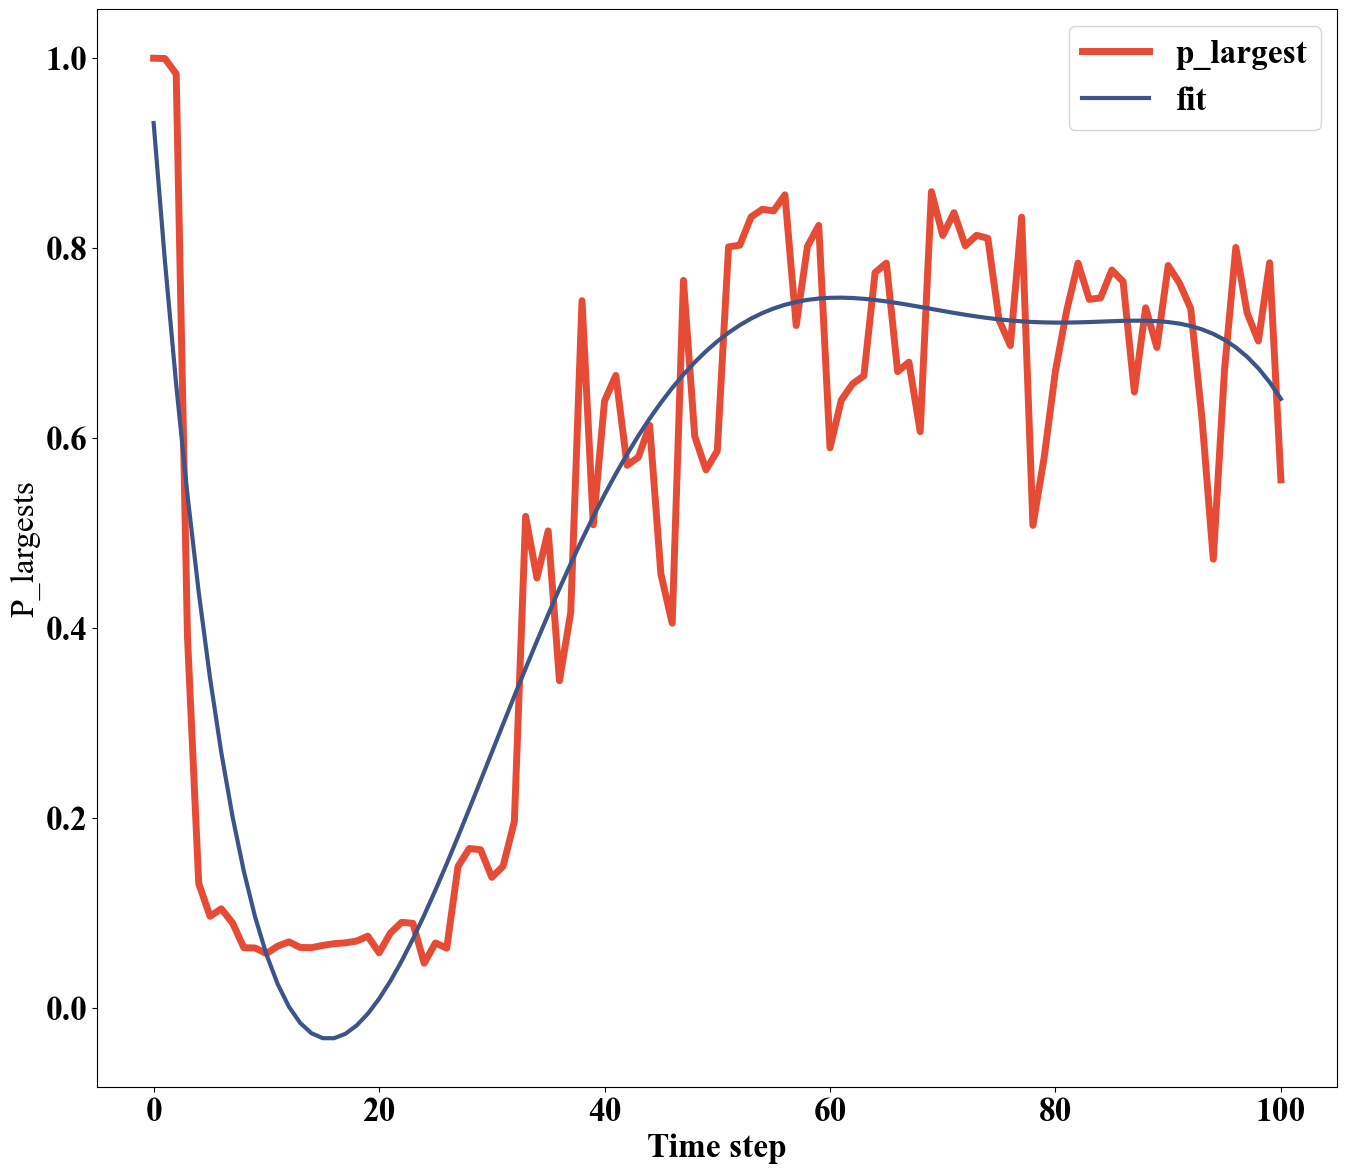

In [ ]:
plt.rc('font', family='Times New Roman') # 设置全局字体为times-newroman
plt.rcParams['font.size'] = 24 # 设置字体大小
plt.rcParams['font.weight'] = 'bold' # 设置字体粗细

plt.figure(figsize=(16,14)) # 设置画布大小

plt.subplot(111) # 设置子图位置
plt.plot(range(len(p_largests)), p_largests, label="p_largest", color = '#E64B35', linewidth = 5) # 绘制移动网络Y上感染比例曲线

# 使用polyfit函数，根据数据点和多项式阶数（比如3），返回一个最小二乘拟合的多项式系数
coeff = np.polyfit(range(len(p_largests)), p_largests, 5)
# 使用poly1d函数，根据系数生成一个多项式函数
f = np.poly1d(coeff)
# 使用这个函数计算拟合曲线上的点
y_fit = f(range(len(p_largests)))
# 使用plot函数，将这些点绘制在折线图上，设置颜色为蓝色
plt.plot(range(len(p_largests)), y_fit, label = 'fit', color = '#3C5488', linewidth = 3)

plt.xlabel("Time step", fontdict={'weight':'bold', 'size':24}) # 设置x轴标签
plt.ylabel("P_largests") # 设置y轴标签

plt.legend()
plt.show()

In [ ]:
# 参数设定
p_largests = []
graphs_dict = graphs.copy()
for i in range(len(y_states)):
    p_largets = []
    X_adj_new = X_adj.copy()
    index_geom = {}
    for k, v in geom_dict_layery.items():
        index_geom[v] = k

    # 根据Y的最新状态更新X网络上的人口流动矩阵
    geoms = []
    for index in list(np.where(y_states[i]==0)[0]):
        geoms.append(index_geom[index])
    indexs = []
    for geom in geoms:
        if geom in geom_dict_layerx.keys():
            indexs.append(geom_dict_layerx[geom])
    for index in indexs:
        X_adj_new[index] = 0
    # 得到了新的x的人口流量矩阵
    p_hj_x = X_adj_new / (X_adj_new.sum(axis=1, keepdims=True)+1) # 对每行进行归一化
    x_states_rate = x_states[i] / np.array(x_states[i]).sum(axis=1, keepdims=True)
    death_rate = [rate[1] for rate in x_states_rate]
    birth_rate = [rate[2] for rate in x_states_rate]

    # 生成子网络
    
    new_graphs = generate_subnetworks(graphs_dict = graphs_dict, failures_probs=death_rate, birth_probs=birth_rate, flow_weights=p_hj_x, X_adj_new=X_adj_new)
    graphs_dict = new_graphs
    # 合成一个大的网络
    big_network = nx.compose_all(list(new_graphs.values()))

    components = nx.connected_components(big_network) # 获取所有的连通子图的节点集合
    largest_component = max(components, key=len) # 找出最大的连通子图的节点集合
    largest_subgraph = big_network.subgraph(largest_component) # 提取出最大的连通子图

    all_node_num = len(big_network.nodes())
    largest_component_num = len(largest_subgraph.nodes())
    p_largest = largest_component_num / all_node_num
    print(f'\n 第{i}次迭代')
    print(f'节点总数：{all_node_num}')
    print(f'最大联通组节点总数：{largest_component_num}')
    print(f'最大联通组占比：{p_largest}')
    p_largests.append(p_largest)


 第0次迭代
节点总数：45813
最大联通组节点总数：458
最大联通组占比：0.009997162377491105

 第1次迭代
节点总数：41222
最大联通组节点总数：379
最大联通组占比：0.009194119644849837

 第2次迭代
节点总数：37208
最大联通组节点总数：310
最大联通组占比：0.008331541603956138

 第3次迭代
节点总数：33387
最大联通组节点总数：87
最大联通组占比：0.002605804654506245

 第4次迭代
节点总数：30395
最大联通组节点总数：32
最大联通组占比：0.0010528047376213193

 第5次迭代
节点总数：28732
最大联通组节点总数：14
最大联通组占比：0.0004872615898649589

 第6次迭代
节点总数：27840
最大联通组节点总数：9
最大联通组占比：0.0003232758620689655

 第7次迭代
节点总数：27447
最大联通组节点总数：6
最大联通组占比：0.00021860312602470214

 第8次迭代
节点总数：27230
最大联通组节点总数：5
最大联通组占比：0.0001836210062431142

 第9次迭代
节点总数：27140
最大联通组节点总数：5
最大联通组占比：0.00018422991893883567

 第10次迭代
节点总数：27088
最大联通组节点总数：5
最大联通组占比：0.0001845835794447726

 第11次迭代
节点总数：27062
最大联通组节点总数：4
最大联通组占比：0.00014780873549626782

 第12次迭代
节点总数：27052
最大联通组节点总数：3
最大联通组占比：0.00011089753068165016

 第13次迭代
节点总数：27052
最大联通组节点总数：3
最大联通组占比：0.00011089753068165016

 第14次迭代
节点总数：27048
最大联通组节点总数：3
最大联通组占比：0.00011091393078970719

 第15次迭代
节点总数：27047
最大联通组节点总数：2
最大联通组占比：7.394535438311088e-05

 第16次迭

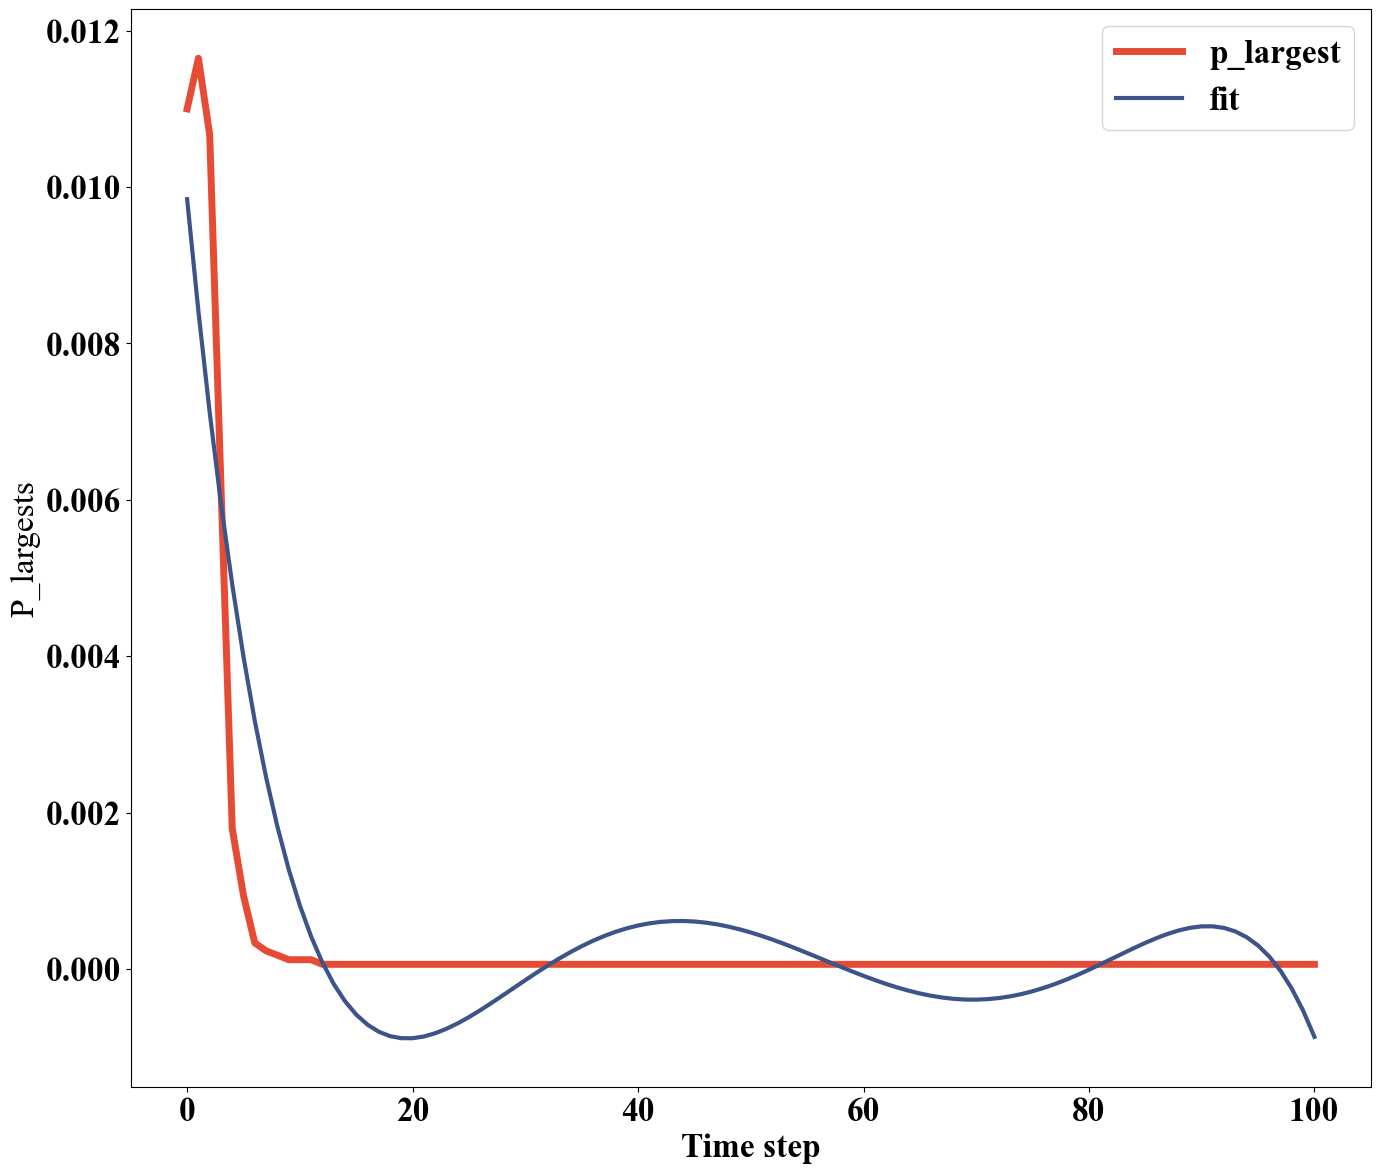

In [ ]:
plt.rc('font', family='Times New Roman') # 设置全局字体为times-newroman
plt.rcParams['font.size'] = 24 # 设置字体大小
plt.rcParams['font.weight'] = 'bold' # 设置字体粗细

plt.figure(figsize=(16,14)) # 设置画布大小

plt.subplot(111) # 设置子图位置
plt.plot(range(len(p_largests)), p_largests, label="p_largest", color = '#E64B35', linewidth = 5) # 绘制移动网络Y上感染比例曲线

# 使用polyfit函数，根据数据点和多项式阶数（比如3），返回一个最小二乘拟合的多项式系数
coeff = np.polyfit(range(len(p_largests)), p_largests, 5)
# 使用poly1d函数，根据系数生成一个多项式函数
f = np.poly1d(coeff)
# 使用这个函数计算拟合曲线上的点
y_fit = f(range(len(p_largests)))
# 使用plot函数，将这些点绘制在折线图上，设置颜色为蓝色
plt.plot(range(len(p_largests)), y_fit, label = 'fit', color = '#3C5488', linewidth = 3)

plt.xlabel("Time step", fontdict={'weight':'bold', 'size':24}) # 设置x轴标签
plt.ylabel("P_largests") # 设置y轴标签

plt.legend()
plt.show()

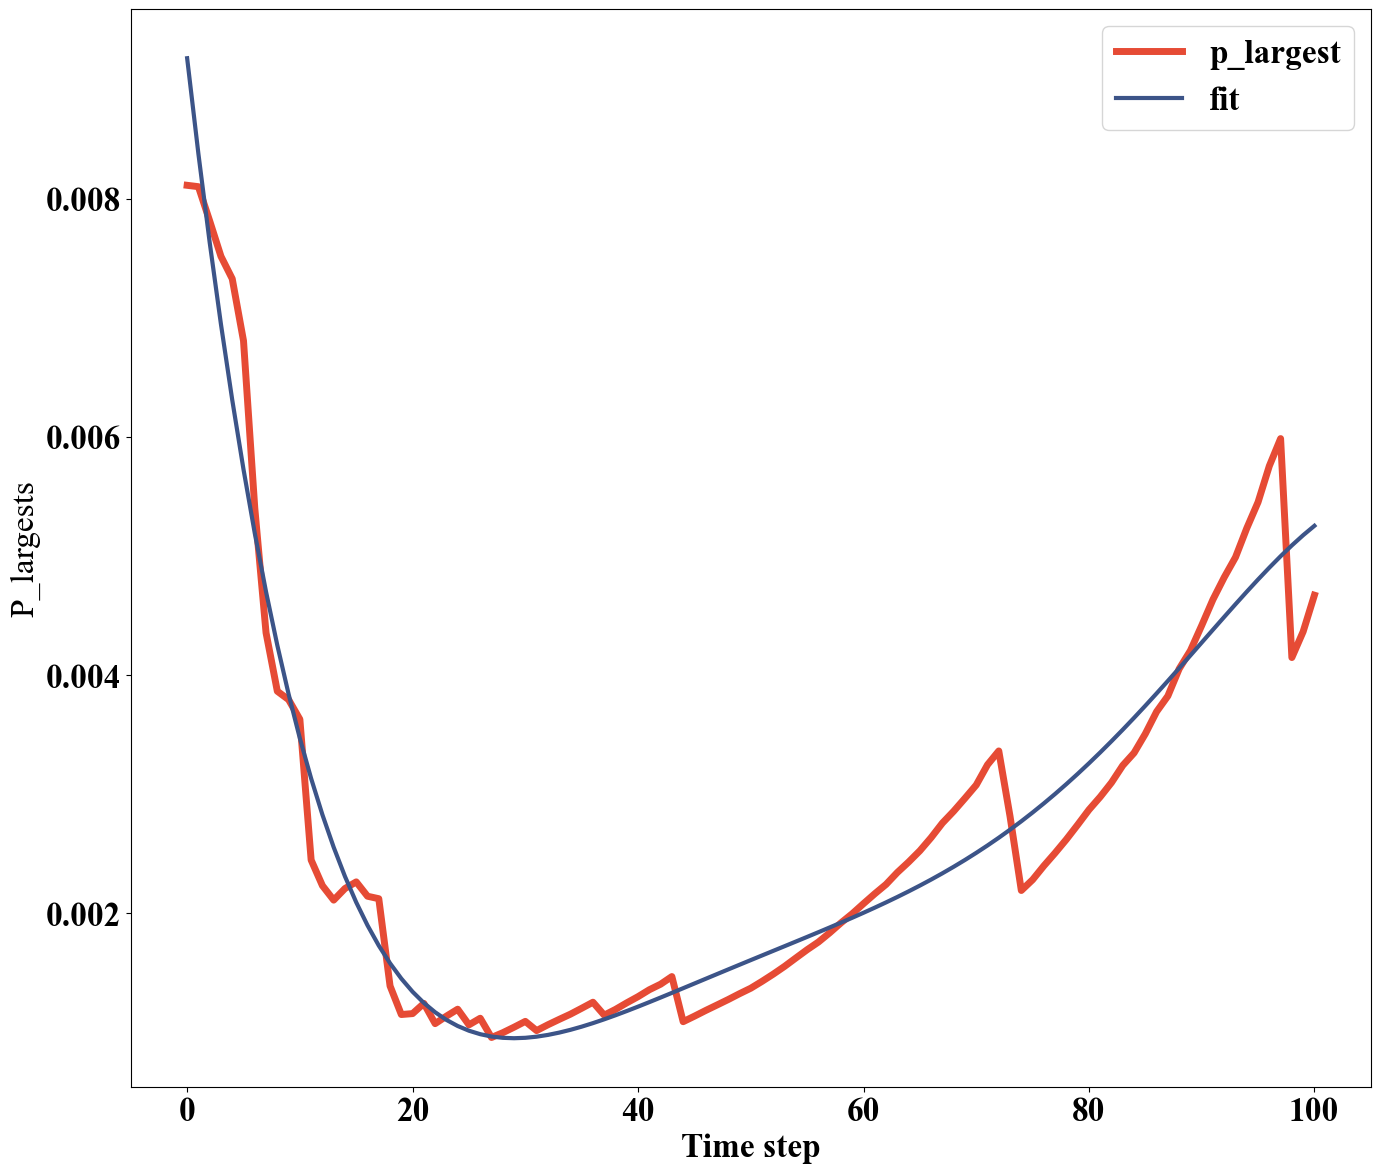

In [ ]:
plt.rc('font', family='Times New Roman') # 设置全局字体为times-newroman
plt.rcParams['font.size'] = 24 # 设置字体大小
plt.rcParams['font.weight'] = 'bold' # 设置字体粗细

plt.figure(figsize=(16,14)) # 设置画布大小

plt.subplot(111) # 设置子图位置
plt.plot(range(len(p_largests)), p_largests, label="p_largest", color = '#E64B35', linewidth = 5) # 绘制移动网络Y上感染比例曲线

# 使用polyfit函数，根据数据点和多项式阶数（比如3），返回一个最小二乘拟合的多项式系数
coeff = np.polyfit(range(len(p_largests)), p_largests, 5)
# 使用poly1d函数，根据系数生成一个多项式函数
f = np.poly1d(coeff)
# 使用这个函数计算拟合曲线上的点
y_fit = f(range(len(p_largests)))
# 使用plot函数，将这些点绘制在折线图上，设置颜色为蓝色
plt.plot(range(len(p_largests)), y_fit, label = 'fit', color = '#3C5488', linewidth = 3)

plt.xlabel("Time step", fontdict={'weight':'bold', 'size':24}) # 设置x轴标签
plt.ylabel("P_largests") # 设置y轴标签

plt.legend()
plt.show()